# Сравнение моделей распознавания дефектов дорожного покрытия

In [11]:
import keras
import shutil
import os

In [12]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
!unzip 5y9wdsg2zt-2.zip
!unrar x 'Concrete Crack Images for Classification.rar'

Выходные данные были обрезаны до нескольких последних строк (5000).
Extracting  Negative/15002.jpg                                            88%  OK 
Extracting  Negative/15003.jpg                                            88%  OK 
Extracting  Negative/15004.jpg                                            88%  OK 
Extracting  Negative/15005.jpg                                            88%  OK 
Extracting  Negative/15006.jpg                                            88%  OK 
Extracting  Negative/15007.jpg                                            88%  OK 
Extracting  Negative/15008.jpg                                            88%  OK 
Extracting  Negative/15009.jpg                                            88%  OK 
Extracting  Negative/15010.jpg                                            88%  OK 
Extracting  Negative/15011.jpg                                            88%  OK 
Extracting  

In [15]:
os.mkdir("/content/Images")

original = r'/content/Positive'
target = r'/content/Images/Positive'

shutil.move(original,target)

original = r'/content/Negative'
target = r'/content/Images/Negative'

shutil.move(original,target)

'/content/Images/Negative/Negative'

In [14]:
pip install split-folders

In [16]:
import splitfolders  

splitfolders.ratio("Images", output="Data1", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

base_dir = '/content/Data1'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

train_pos_dir = os.path.join(train_dir, 'Positive')
train_neg_dir = os.path.join(train_dir, 'Negative')
val_pos_dir = os.path.join(validation_dir, 'Positive')
val_neg_dir = os.path.join(validation_dir, 'Negative')

Copying files: 40000 files [00:07, 5367.41 files/s]


In [17]:
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(120, 120), 
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(120, 120),
        batch_size=20,
        class_mode='categorical')

Found 32000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


## EfficientNet

In [19]:
from tensorflow.keras.applications import EfficientNetB5
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential

base_model = EfficientNetB5(include_top=False, weights="imagenet", input_shape=(120, 120, 3))

In [20]:
base_model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 120, 120, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 120, 120, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [21]:
base_model.trainable = False
efficient_net = keras.models.Sequential()
efficient_net.add(base_model)
efficient_net.add(Flatten())
efficient_net.add(Dense(512, activation='relu'))
efficient_net.add(Dense(2, activation='sigmoid'))
efficient_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 4, 4, 2048)       28513527  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 45,292,281
Trainable params: 16,778,754
Non-trainable params: 28,513,527
_________________________________________________________________


In [22]:
efficient_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [23]:
history = efficient_net.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Epoch 1/5
100/100 [==============================] - 34s 132ms/step - loss: 6.2122 - tp: 1790.0000 - fp: 1801.0000 - tn: 199.0000 - fn: 210.0000 - accuracy: 0.4972 - precision: 0.4985 - recall: 0.8950 - auc: 0.4939 - val_loss: 1.1042 - val_tp: 1000.0000 - val_fp: 1000.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5565
Epoch 2/5
100/100 [==============================] - 9s 94ms/step - loss: 0.9184 - tp: 1997.0000 - fp: 2000.0000 - tn: 0.0000e+00 - fn: 3.0000 - accuracy: 0.4992 - precision: 0.4996 - recall: 0.9985 - auc: 0.5035 - val_loss: 0.6896 - val_tp: 1000.0000 - val_fp: 1000.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5170
Epoch 3/5
100/100 [==============================] - 9s 94ms/step - loss: 0.9378 - tp: 1984.0000 - fp: 1977.0000 - tn: 23.0000 - fn: 16.0000 - accuracy: 0.5017 - precision: 0.5009 - recall: 0.9920 -

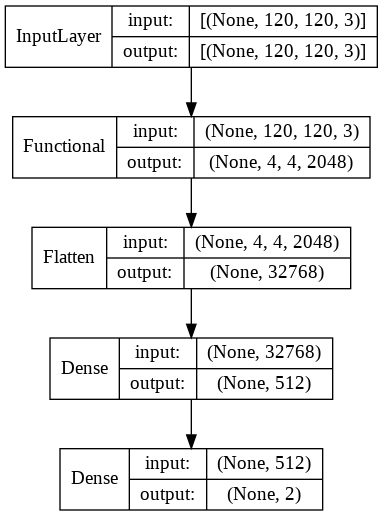

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(efficient_net, to_file='efficient_net.png', show_layer_names=False, show_shapes=True)

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

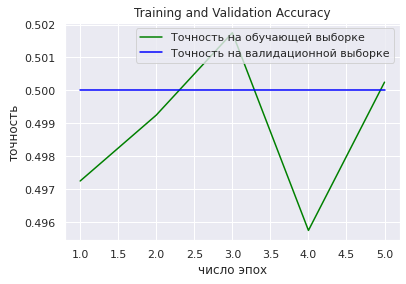

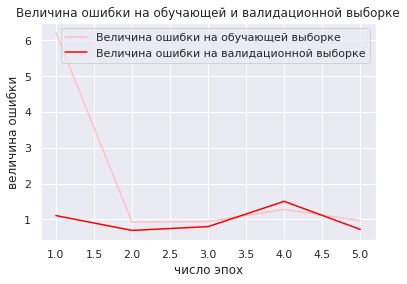

In [26]:
plt.plot(epochs, acc, color='green', label='Точность на обучающей выборке')
plt.plot(epochs, val_acc, color='blue', label='Точность на валидационной выборке')
plt.title('Training and Validation Accuracy')
plt.ylabel('точность')
plt.xlabel('число эпох')
plt.legend()

plt.figure()
plt.plot(epochs, loss, color='pink', label='Величина ошибки на обучающей выборке')
plt.plot(epochs, val_loss, color='red', label='Величина ошибки на валидационной выборке')
plt.title('Величина ошибки на обучающей и валидационной выборке')
plt.xlabel('число эпох')
plt.ylabel('величина ошибки')
plt.legend()

plt.show()

In [27]:
print('Точность EfficientNetB5 на тестовой выборке = {} %'.format(val_acc[-1] * 100), '. Величина ошибки = {}'.format(val_loss[-1]))

Точность EfficientNetB5 на тестовой выборке = 50.0 % . Величина ошибки = 0.7181484699249268


## ResNet-50

In [28]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [29]:
res_net = Sequential()
res_net.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

res_net.add(Dense(2, activation='softmax'))
res_net.layers[0].trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [30]:
res_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [31]:
res_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [32]:
history = res_net.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Epoch 1/5
100/100 [==============================] - 11s 68ms/step - loss: 0.6571 - tp: 2256.0000 - fp: 1744.0000 - tn: 1256.0000 - fn: 744.0000 - accuracy: 0.5853 - precision: 0.5640 - recall: 0.7520 - auc: 0.5889 - val_loss: 0.6207 - val_tp: 670.0000 - val_fp: 330.0000 - val_tn: 670.0000 - val_fn: 330.0000 - val_accuracy: 0.6700 - val_precision: 0.6700 - val_recall: 0.6700 - val_auc: 0.8259
Epoch 2/5
100/100 [==============================] - 5s 53ms/step - loss: 0.5881 - tp: 1585.0000 - fp: 415.0000 - tn: 1585.0000 - fn: 415.0000 - accuracy: 0.7925 - precision: 0.7925 - recall: 0.7925 - auc: 0.8684 - val_loss: 0.5463 - val_tp: 945.0000 - val_fp: 55.0000 - val_tn: 945.0000 - val_fn: 55.0000 - val_accuracy: 0.9450 - val_precision: 0.9450 - val_recall: 0.9450 - val_auc: 0.9901
Epoch 3/5
100/100 [==============================] - 5s 53ms/step - loss: 0.5186 - tp: 1870.0000 - fp: 130.0000 - tn: 1870.0000 - fn: 130.0000 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9780

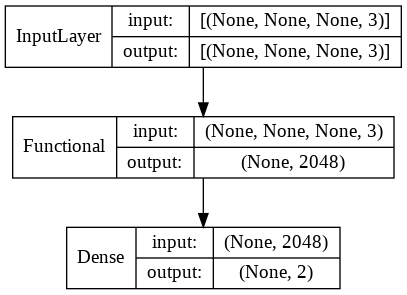

In [33]:
plot_model(res_net, to_file='res_net.png', show_layer_names=False, show_shapes=True)

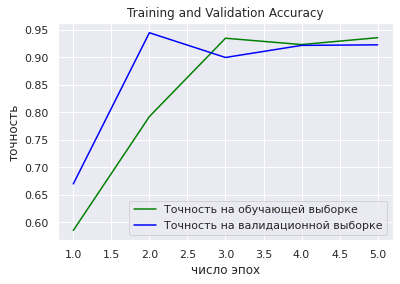

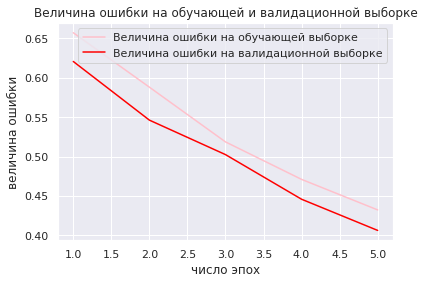

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, color='green', label='Точность на обучающей выборке')
plt.plot(epochs, val_acc, color='blue', label='Точность на валидационной выборке')
plt.title('Training and Validation Accuracy')
plt.ylabel('точность')
plt.xlabel('число эпох')
plt.legend()

plt.figure()
plt.plot(epochs, loss, color='pink', label='Величина ошибки на обучающей выборке')
plt.plot(epochs, val_loss, color='red', label='Величина ошибки на валидационной выборке')
plt.title('Величина ошибки на обучающей и валидационной выборке')
plt.xlabel('число эпох')
plt.ylabel('величина ошибки')
plt.legend()

plt.show()

In [35]:
print('Точность ResNet-50 на тестовой выборке = {} %'.format(val_acc[-1] * 100), '. Величина ошибки = {}'.format(val_loss[-1]))

Точность ResNet-50 на тестовой выборке = 92.29999780654907 % . Величина ошибки = 0.4063238203525543


## VGG16

In [36]:
from tensorflow.keras.applications.vgg16 import VGG16

In [37]:
vgg_net = Sequential()
vgg_net.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))
vgg_net.add(Dense(2, activation='softmax'))
vgg_net.layers[0].trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [38]:
vgg_net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
vgg_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [40]:
history = vgg_net.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Epoch 1/5
100/100 [==============================] - 10s 63ms/step - loss: 0.4709 - tp: 2580.0000 - fp: 420.0000 - tn: 2580.0000 - fn: 420.0000 - accuracy: 0.8600 - precision: 0.8600 - recall: 0.8600 - auc: 0.9401 - val_loss: 0.2724 - val_tp: 982.0000 - val_fp: 18.0000 - val_tn: 982.0000 - val_fn: 18.0000 - val_accuracy: 0.9820 - val_precision: 0.9820 - val_recall: 0.9820 - val_auc: 0.9981
Epoch 2/5
100/100 [==============================] - 6s 56ms/step - loss: 0.2075 - tp: 1961.0000 - fp: 39.0000 - tn: 1961.0000 - fn: 39.0000 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9975 - val_loss: 0.1476 - val_tp: 991.0000 - val_fp: 9.0000 - val_tn: 991.0000 - val_fn: 9.0000 - val_accuracy: 0.9910 - val_precision: 0.9910 - val_recall: 0.9910 - val_auc: 0.9996
Epoch 3/5
100/100 [==============================] - 6s 55ms/step - loss: 0.1231 - tp: 1976.0000 - fp: 24.0000 - tn: 1976.0000 - fn: 24.0000 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9992 - val_lo

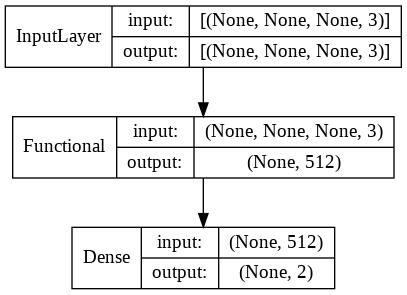

In [41]:
plot_model(vgg_net, to_file='vgg_net.png', show_layer_names=False, show_shapes=True)

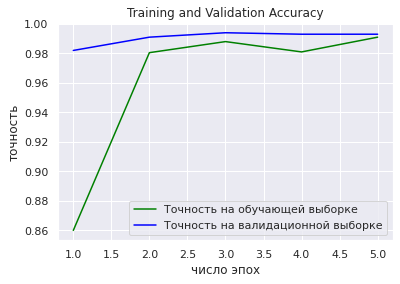

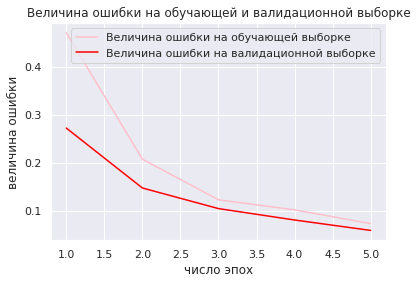

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, color='green', label='Точность на обучающей выборке')
plt.plot(epochs, val_acc, color='blue', label='Точность на валидационной выборке')
plt.title('Training and Validation Accuracy')
plt.ylabel('точность')
plt.xlabel('число эпох')
plt.legend()

plt.figure()
plt.plot(epochs, loss, color='pink', label='Величина ошибки на обучающей выборке')
plt.plot(epochs, val_loss, color='red', label='Величина ошибки на валидационной выборке')
plt.title('Величина ошибки на обучающей и валидационной выборке')
plt.xlabel('число эпох')
plt.ylabel('величина ошибки')
plt.legend()

plt.show()

In [43]:
print('Точность VGG16 на тестовой выборке = {} %'.format(val_acc[-1] * 100), '. Величина ошибки = {}'.format(val_loss[-1]))

Точность VGG16 на тестовой выборке = 99.29999709129333 % . Величина ошибки = 0.05922917276620865


## Сравнение точности 

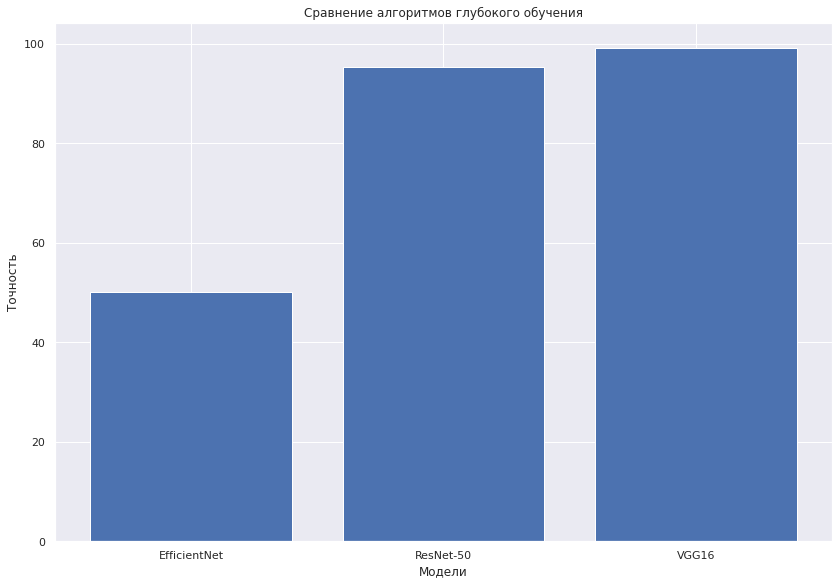

In [44]:
fig = plt.figure()
ax = fig.add_axes([0,0, 1.8, 1.8])
algo = ['EfficientNet','ResNet-50', 'VGG16']
acc = [50, 95.2, 99.2]
ax.bar(algo, acc)
ax.set_xlabel('Модели')
ax.set_ylabel('Точность')
ax.set_title('Сравнение алгоритмов глубокого обучения')
plt.show()